# **Setup**

- https://towardsdatascience.com/how-to-make-proximity-maps-with-python-da398788e058/

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# !pip install geopandas --quiet
import geopandas as gpd

# !pip install geopy --quiet
from geopy.distance import great_circle

# **Data Import**

In [32]:
# SEC schools with coordinates (coords by ChatGPT4):
data = {
    'school': ['Alabama', 'LSU', 'Ole Miss', 'Miss State', 
               'Auburn', 'Arkansas', 'Missouri', 'Vanderbilt', 
               'Tennessee', 'Florida', 'Georgia', 'Kentucky', 
               'S. Carolina', 'TAMU', 'Texas', 'Oklahoma'],
    'latitude': [33.209, 30.412, 34.365, 33.456, 
                 32.603, 36.068, 38.951, 36.162, 
                 35.960, 29.651, 33.950, 38.049, 
                 34.000, 30.620, 30.284, 35.222],
    'longitude': [-87.538, -91.177, -89.526, -88.811, 
                  -85.484, -94.172, -92.328, -86.784, 
                  -83.920, -82.324, -83.377, -84.500, 
                  -81.034, -96.340, -97.740, -97.445]
}

df = pd.DataFrame(data)

# **Proximity Map**

In [33]:
# Pick a school to plot the distance from. 
# Use the same name as in the data dict:
SCHOOL = 'Texas'

# Set the grid resolution.
# Larger = higher res and smoother contours:
RESOLUTION = 500

In [34]:
# Get coordinates for SCHOOL:
school_index = df[df['school'] == SCHOOL].index[0]
school_coords = df.loc[school_index, ['latitude', 'longitude']].to_numpy()
school_coords

array([np.float64(30.284), np.float64(-97.74)], dtype=object)

# **Create Grid**

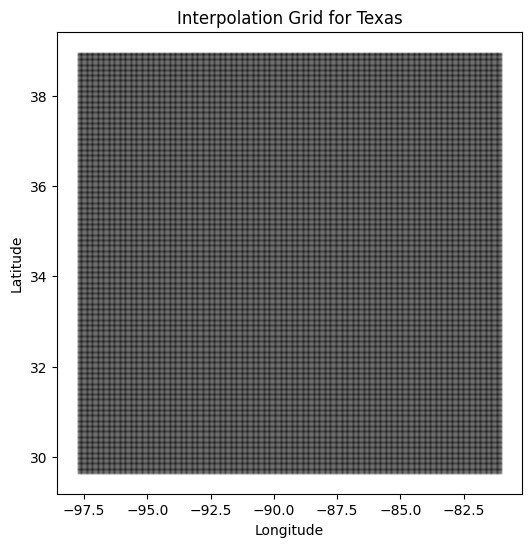

In [35]:
# Create grid of points for interpolation:
x_min, x_max = df['longitude'].min(), df['longitude'].max()
y_min, y_max = df['latitude'].min(), df['latitude'].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, RESOLUTION), 
                     np.linspace(y_min, y_max, RESOLUTION))

# Plot the Meshgrid:
plt.figure(figsize=(6,6))
plt.scatter(xx, yy, s=1, c='k', alpha=0.1)
plt.title(f'Interpolation Grid for {SCHOOL}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# **Calculating Distances**

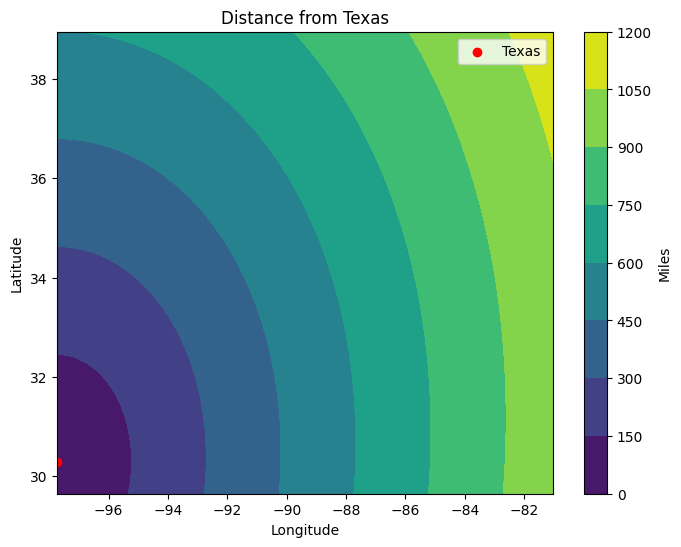

In [38]:
# Calculate distances from SCHOOL to every point in grid:
distances = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        point_coords = (yy[i, j], xx[i, j])
        distances[i, j] = great_circle(school_coords, point_coords).miles

# Plot the distances:
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, distances, cmap='viridis')
plt.colorbar(label='Miles')
plt.scatter(school_coords[1], school_coords[0], c='r', label=SCHOOL)
plt.title(f'Distance from {SCHOOL}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# **Create Map**

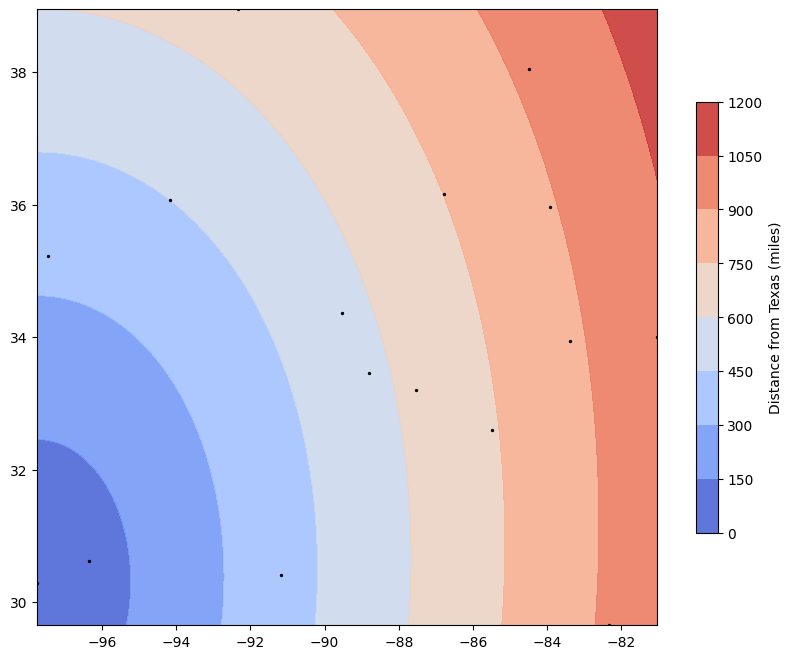

In [18]:
# Create the color-filled contour map:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
contour = ax.contourf(xx, yy, distances, 
                      cmap='coolwarm', 
                      alpha=0.9)
cbar = fig.colorbar(contour, ax=ax, shrink=0.7)
cbar.set_label(f'Distance from {SCHOOL} (miles)')
ax.scatter(df['longitude'], df['latitude'], s=2, color='black')

# **Adding State Boundaries**

In [41]:
# Load state boundaries from US Census Bureau:
url = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip'
states = gpd.read_file(url)

# Filter states within the map limits:
states = states.cx[x_min:x_max, y_min:y_max]

# Plot the state boundaries:
# states.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
# plt.title(f'Distance from {SCHOOL} to SEC Schools')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# Plot the state boundaries:
states.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

<Axes: >

# **Adding State Labels**

In [31]:
# Load state boundaries from US Census Bureau:
url = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip'
states = gpd.read_file(url)

# Filter states within the map limits:
states = states.cx[x_min:x_max, y_min:y_max]

# Add labels for the schools:
for i, school in enumerate(df['school']):
    ax.annotate(
        school, 
        (df['longitude'][i], df['latitude'][i]),
        textcoords="offset points",
        xytext=(2, 1),
        ha='left',
        fontsize=8
    )

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Distance from {SCHOOL} to Other SEC Schools')
fig.savefig('distance_map.png', dpi=600)
plt.show()

KeyError: 'school'

# **Finding Shortest & Longest Avg Distance**

In [21]:
# Calculate average distances between each school and the others
coords = df[['latitude', 'longitude']].to_numpy()
distance_matrix = np.zeros((len(coords), len(coords)))

for i in range(len(coords)):
    for j in range(len(coords)):
        distance_matrix[i, j] = great_circle((coords[i][0], coords[i][1]), 
                                             (coords[j][0], coords[j][1])).miles

avg_distances = distance_matrix.mean(axis=1)
shortest_avg_distance_school = df['school'].iloc[avg_distances.argmin()]
longest_avg_distance_school = df['school'].iloc[avg_distances.argmax()]

print(f"School with shortest average distance: {shortest_avg_distance_school}")
print(f"School with longest average distance: {longest_avg_distance_school}")

School with shortest average distance: Miss State
School with longest average distance: Texas


# **A**

In [ ]:
# Calculate minimum distance to any school from every point in the grid:
distances = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        point_coords = (yy[i, j], xx[i, j])
        distances[i, j] = min(great_circle(point_coords, 
                                           (df.loc[k, 'latitude'], 
                                            df.loc[k, 'longitude'])).miles 
                                   for k in range(len(df)))

In [23]:
# Create grid of points for interpolation
x_min, x_max = -107, -75
y_min, y_max = 23.5, 42.5 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, RESOLUTION), 
                     np.linspace(y_min, y_max, RESOLUTION))

# Filter states within the map limits
states = states.cx[-100:-80, 25:36.5]

# **Final Code**

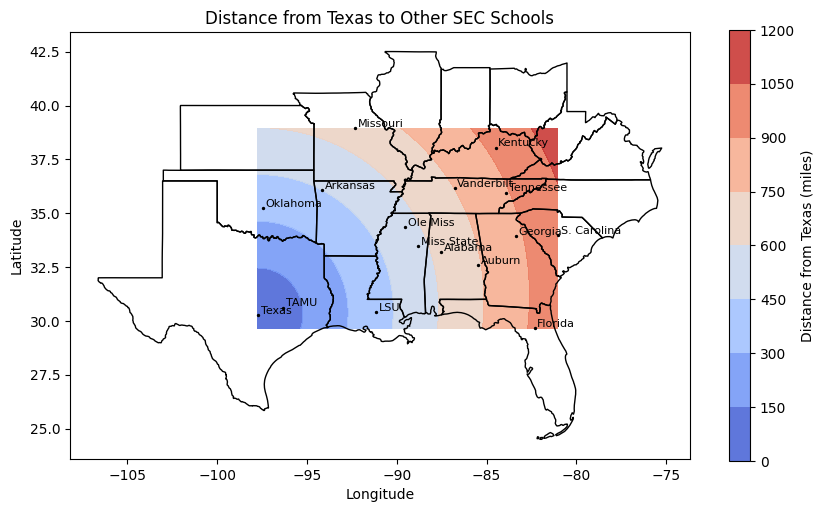

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopy.distance import great_circle

# SEC schools with coordinates (coords by ChatGPT4):
data = {
    'school': ['Alabama', 'LSU', 'Ole Miss', 'Miss State', 
               'Auburn', 'Arkansas', 'Missouri', 'Vanderbilt', 
               'Tennessee', 'Florida', 'Georgia', 'Kentucky', 
               'S. Carolina', 'TAMU', 'Texas', 'Oklahoma'],
    'latitude': [33.209, 30.412, 34.365, 33.456, 
                 32.603, 36.068, 38.951, 36.162, 
                 35.960, 29.651, 33.950, 38.049, 
                 34.000, 30.620, 30.284, 35.222],
    'longitude': [-87.538, -91.177, -89.526, -88.811, 
                  -85.484, -94.172, -92.328, -86.784, 
                  -83.920, -82.324, -83.377, -84.500, 
                  -81.034, -96.340, -97.740, -97.445]
}

df = pd.DataFrame(data)

# Pick a school to plot the distance from. 
# Use the same name as in the previous data dict:
SCHOOL = 'Texas'

# Set the grid resolution.
# Larger = higher res and smoother contours:
RESOLUTION = 500

# Get coordinates for SCHOOL:
school_index = df[df['school'] == SCHOOL].index[0]
school_coords = df.loc[school_index, ['latitude', 'longitude']].to_numpy()

# Create grid of points for interpolation:
x_min, x_max = df['longitude'].min(), df['longitude'].max()
y_min, y_max = df['latitude'].min(), df['latitude'].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, RESOLUTION), 
                     np.linspace(y_min, y_max, RESOLUTION))

# Calculate distances from SCHOOL to every point in grid:
distances = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        point_coords = (yy[i, j], xx[i, j])
        distances[i, j] = great_circle(school_coords, point_coords).miles

# Create the color-filled contour map:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
contour = ax.contourf(xx, yy, distances, 
                      cmap='coolwarm', 
                      alpha=0.9)
cbar = fig.colorbar(contour, ax=ax, shrink=0.7)
cbar.set_label(f'Distance from {SCHOOL} (miles)')
ax.scatter(df['longitude'], df['latitude'], s=2, color='black')

# Load state boundaries from US Census Bureau:
url = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip'
states = gpd.read_file(url)

# Filter states within the map limits:
states = states.cx[x_min:x_max, y_min:y_max]

# Plot the state boundaries:
states.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

# Add labels for the schools:
for i, school in enumerate(df['school']):
    ax.annotate(
        school, 
        (df['longitude'][i], df['latitude'][i]),
        textcoords="offset points",
        xytext=(2, 1),
        ha='left',
        fontsize=8
    )

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Distance from {SCHOOL} to Other SEC Schools')

# fig.savefig('distance_map.png', dpi=600)
plt.show()